In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os


Load and preprocess dataset

In [23]:
def load_mnist(binary_classification=True):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    if binary_classification:
        train = [(x, float(y == 0)) for x, y in train]
        test = [(x, float(y == 0)) for x, y in test]

    train_loader = DataLoader(train, batch_size=64, shuffle=True)
    test_loader = DataLoader(test, batch_size=64, shuffle=False)
    return train_loader, test_loader


Logistic Regression Model

In [24]:
class LogisticRegressionModel:
    def __init__(self, input_dim):
        self.w = np.zeros((input_dim, 1))
        self.b = 0

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def predict(self, X):
        return self.sigmoid(X @ self.w + self.b)

    def loss(self, X, y):
        m = len(y)
        preds = self.predict(X)
        loss = -np.mean(y * np.log(preds + 1e-8) + (1 - y) * np.log(1 - preds + 1e-8))
        return loss

    def gradient(self, X, y):
        m = len(y)
        preds = self.predict(X)
        error = preds - y
        dw = (X.T @ error) / m
        db = np.mean(error)
        return dw, db

 SGD Optimizer (Student: extend this)

In [25]:
def sgd_train(model, train_loader, lr=0.01, num_epochs=10, decay=False, k=0.01):
    loss_history = []
    t = 0  # iteration counter

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            # Iteration-based learning rate decay
            if decay:
                current_lr = lr / (1 + k * t)
            else:
                current_lr = lr
            t += 1

            dw, db = model.gradient(X, y)
            model.w -= current_lr * dw
            model.b -= current_lr * db

            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history

SGD-Momentum

In [26]:
def sgd_momentum_train(model, train_loader, lr=0.01, num_epochs=10, beta=0.9):
    loss_history = []
    v_w = np.zeros_like(model.w)
    v_b = 0

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            dw, db = model.gradient(X, y)

            # Update velocities
            v_w = beta * v_w + (1 - beta) * dw
            v_b = beta * v_b + (1 - beta) * db

            # Update parameters
            model.w -= lr * v_w
            model.b -= lr * v_b

            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history

SGD-Adam 

In [27]:
def sgd_adam_train(model, train_loader, lr=0.01, num_epochs=10, beta1=0.9, beta2=0.999, epsilon=1e-8, bias_correction=True):
    loss_history = []
    m_w = np.zeros_like(model.w)
    v_w = np.zeros_like(model.w)
    m_b = 0
    v_b = 0
    t = 0

    for epoch in range(num_epochs):
        for batch in train_loader:
            x_batch, y_batch = batch
            X = x_batch.numpy()
            y = y_batch.numpy().reshape(-1, 1)

            dw, db = model.gradient(X, y)

            # Increment timestep
            t += 1

            # Update biased first moment estimate
            m_w = beta1 * m_w + (1 - beta1) * dw
            m_b = beta1 * m_b + (1 - beta1) * db

            # Update biased second raw moment estimate
            v_w = beta2 * v_w + (1 - beta2) * (dw ** 2)
            v_b = beta2 * v_b + (1 - beta2) * (db ** 2)

            # Bias correction
            if bias_correction:
                m_w_hat = m_w / (1 - beta1 ** t)
                m_b_hat = m_b / (1 - beta1 ** t)
                v_w_hat = v_w / (1 - beta2 ** t)
                v_b_hat = v_b / (1 - beta2 ** t)
            else:
            # No bias correction
                m_w_hat = m_w
                m_b_hat = m_b
                v_w_hat = v_w
                v_b_hat = v_b

            # Update parameters
            model.w -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
            model.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

            loss = model.loss(X, y)
            loss_history.append(loss)

    return loss_history


Plotting and Evaluation

In [28]:
def moving_average(data, window_size=50):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_loss(losses, label='Loss', color=None, linestyle='-', smooth=True, window_size=50):
    if smooth:
        losses = moving_average(losses, window_size)
    plt.plot(losses, label=label, color=color, linestyle=linestyle)


 Main Function

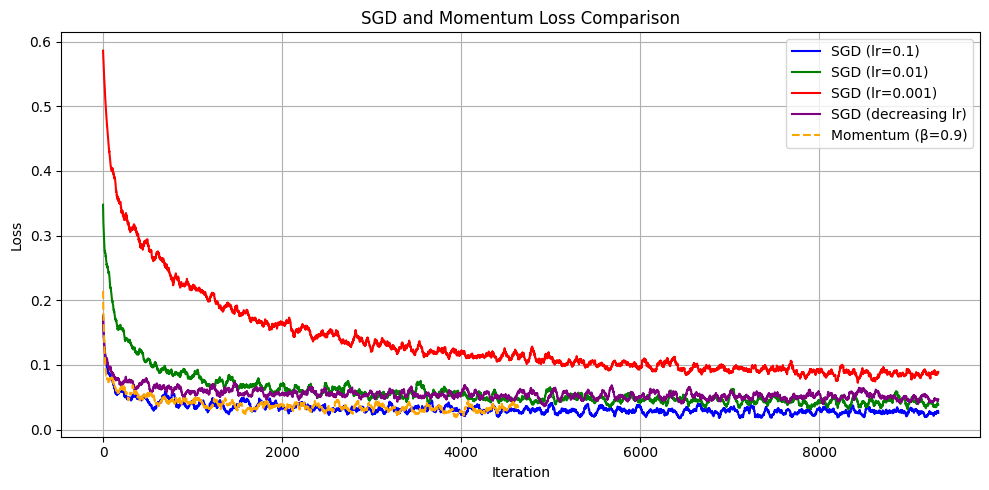

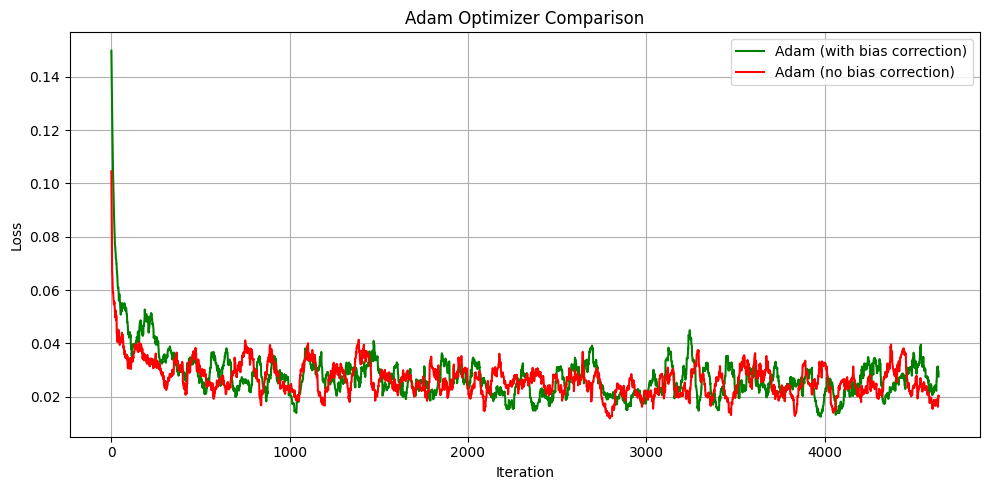

Final SGD lr=0.1 Loss: 0.0027
Final SGD lr=0.01 Loss: 0.0219
Final SGD lr=0.001 Loss: 0.1479
Final SGD (decreasing lr) Loss: 0.0279
Final Momentum Loss: 0.0358
Final Adam (bias corrected) Loss: 0.0180
Final Adam (no bias) Loss: 0.0003


In [29]:
if __name__ == '__main__':
    import os

    # Load the MNIST dataset (binary classification: 0 vs not-0)
    train_loader, test_loader = load_mnist()
    input_dim = 28 * 28

    # =======================================
    # Train models using different optimizers
    # =======================================

    # Vanilla SGD with different constant learning rates
    model_sgd_1 = LogisticRegressionModel(input_dim)
    loss_sgd_1 = sgd_train(model_sgd_1, train_loader, lr=0.1)

    model_sgd_2 = LogisticRegressionModel(input_dim)
    loss_sgd_2 = sgd_train(model_sgd_2, train_loader, lr=0.01)

    model_sgd_3 = LogisticRegressionModel(input_dim)
    loss_sgd_3 = sgd_train(model_sgd_3, train_loader, lr=0.001)

    # SGD with decreasing learning rate
    model_sgd_decay = LogisticRegressionModel(input_dim)
    loss_sgd_decay = sgd_train(model_sgd_decay, train_loader, lr=0.1, decay=True, k=0.01)

    # SGD with Momentum
    model_momentum = LogisticRegressionModel(input_dim)
    loss_momentum = sgd_momentum_train(model_momentum, train_loader, lr=0.1, num_epochs=5, beta=0.9)

    # Adam Optimizer with bias correction
    model_adam_bias = LogisticRegressionModel(input_dim)
    loss_adam_bias = sgd_adam_train(model_adam_bias, train_loader, lr=0.01, num_epochs=5, bias_correction=True)

    # Adam Optimizer without bias correction
    model_adam_no_bias = LogisticRegressionModel(input_dim)
    loss_adam_no_bias = sgd_adam_train(model_adam_no_bias, train_loader, lr=0.01, num_epochs=5, bias_correction=False)

    # ============================
    # Plot 1: SGD + Momentum
    # ============================
    plt.figure(figsize=(10, 5))
    plot_loss(loss_sgd_1, label='SGD (lr=0.1)', color='blue')
    plot_loss(loss_sgd_2, label='SGD (lr=0.01)', color='green')
    plot_loss(loss_sgd_3, label='SGD (lr=0.001)', color='red')
    plot_loss(loss_sgd_decay, label='SGD (decreasing lr)', color='purple')
    plot_loss(loss_momentum, label='Momentum (β=0.9)', color='orange', linestyle='--')

    plt.title("SGD and Momentum Loss Comparison")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    os.makedirs("plots", exist_ok=True)
    plt.savefig('plots/sgd_momentum.png')
    plt.show()

    # ============================
    # Plot 2: Adam Comparison
    # ============================
    plt.figure(figsize=(10, 5))
    plot_loss(loss_adam_bias, label='Adam (with bias correction)', color='green')
    plot_loss(loss_adam_no_bias, label='Adam (no bias correction)', color='red')

    plt.title("Adam Optimizer Comparison")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.savefig('plots/adam_comparison.png')
    plt.show()

    # ============================
    # Print Final Loss Values
    # ============================
    print(f"Final SGD lr=0.1 Loss: {loss_sgd_1[-1]:.4f}")
    print(f"Final SGD lr=0.01 Loss: {loss_sgd_2[-1]:.4f}")
    print(f"Final SGD lr=0.001 Loss: {loss_sgd_3[-1]:.4f}")
    print(f"Final SGD (decreasing lr) Loss: {loss_sgd_decay[-1]:.4f}")
    print(f"Final Momentum Loss: {loss_momentum[-1]:.4f}")
    print(f"Final Adam (bias corrected) Loss: {loss_adam_bias[-1]:.4f}")
    print(f"Final Adam (no bias) Loss: {loss_adam_no_bias[-1]:.4f}")
